In [ ]:
from numpy.fft import fft, ifft, fftfreq
import numpy as np
import pandas as pd

# Load CSV
df = pd.read_csv("C:/Users/Mritunjay Maddhesiya/OneDrive/Desktop/MT5/8_Fourier/SOL_1H.csv")
prices = df['close'].values
n = len(prices)

# FFT
fft_values = fft(prices)
freqs = fftfreq(n)

######################Cycle Detection########################
# Identify dominant cycles (e.g., top 3 largest amplitudes)
amplitudes = np.abs(fft_values)
top_indices = amplitudes.argsort()[-3:]  # top 3
dominant_cycle = np.real(ifft(np.where(np.isin(range(n), top_indices), fft_values, 0)))

# Trading signal: price above cycle → sell, below → buy
df['Cycle'] = dominant_cycle
# Initialize Signal column
df['Signal'] = 0
# Use .loc to assign safely
df.loc[prices > df['Cycle'], 'Signal'] = -1  # sell
df.loc[prices < df['Cycle'], 'Signal'] = 1   # buy



In [ ]:
########################Noise Reduction (Low-pass filter)########################
k = 20  # number of low frequencies to keep
fft_filtered = np.copy(fft_values)
fft_filtered[k:-k] = 0
smoothed_prices = np.real(ifft(fft_filtered))

df['Smoothed'] = smoothed_prices

# Signal: cross of raw price and smoothed price
df['Signal_LowPass'] = 0
df.loc[prices > smoothed_prices, 'Signal_LowPass'] = 1
df.loc[prices < smoothed_prices, 'Signal_LowPass'] = -1



In [ ]:

################Feature Generation########################
# Energy of low/high frequencies
low_freq_energy = np.sum(np.abs(fft_values[:k])**2)
high_freq_energy = np.sum(np.abs(fft_values[k:])**2)

# Spectral entropy (randomness of returns in frequency domain)
prob_spec = np.abs(fft_values)**2 / np.sum(np.abs(fft_values)**2)
spectral_entropy = -np.sum(prob_spec * np.log(prob_spec + 1e-12))

# Add as ML features
features = {
    'LowFreqEnergy': low_freq_energy,
    'HighFreqEnergy': high_freq_energy,
    'SpectralEntropy': spectral_entropy
}

print("Low Frequency Energy:", low_freq_energy)
print("High Frequency Energy:", high_freq_energy)
print("Spectral Entropy:", spectral_entropy)


Low Frequency Energy: 7980481875.637191
High Frequency Energy: 16917774.96280924
Spectral Entropy: 0.03373426095697271


In [ ]:
###############Volatility Filter################
total_energy = np.sum(np.abs(fft_values)**2)
high_freq_ratio = np.sum(np.abs(fft_values[k:])**2) / total_energy

# Threshold: if too noisy, skip trades
volatility_threshold = 0.6
trade_allowed = high_freq_ratio < volatility_threshold
print("Trade allowed (based on volatility filter):", trade_allowed)
df['TradeAllowed'] = high_freq_ratio < volatility_threshold


Trade allowed (based on volatility filter): True


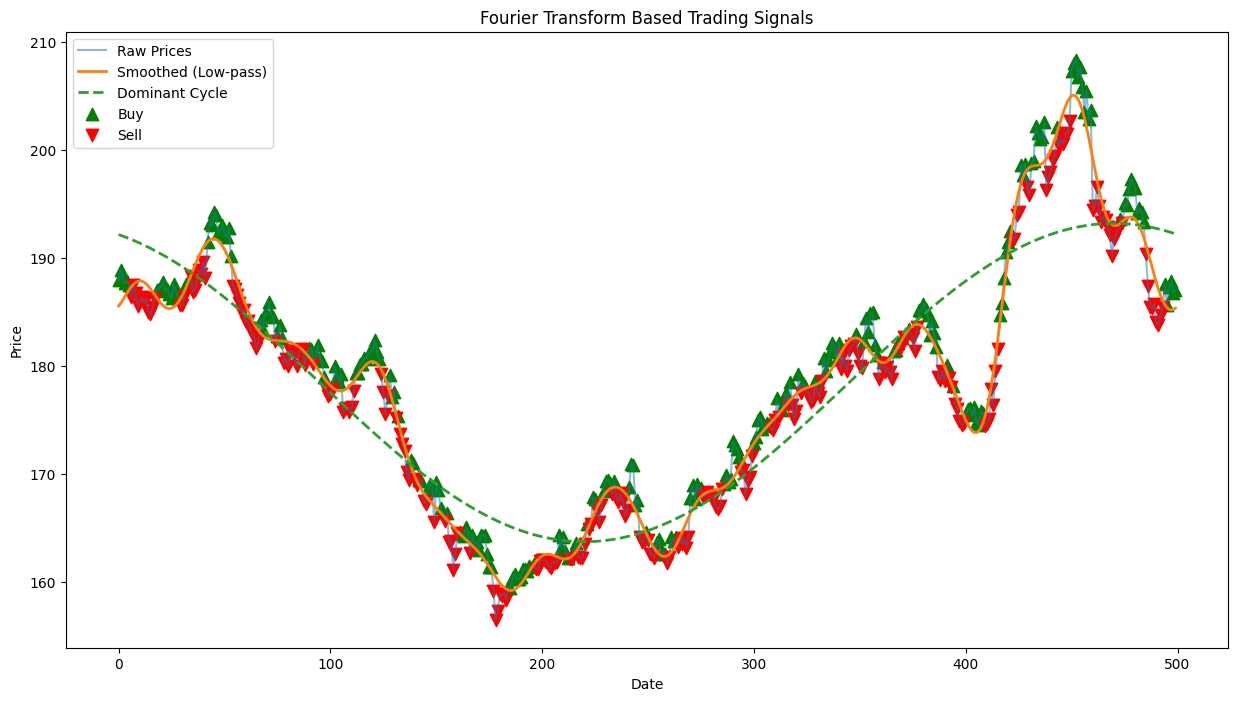

In [15]:
df['FilteredSignal'] = df['Signal_LowPass'] * df['TradeAllowed']

import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(df.index, df['close'], label="Raw Prices", alpha=0.5)
plt.plot(df.index, df['Smoothed'], label="Smoothed (Low-pass)", linewidth=2)
plt.plot(df.index, df['Cycle'], label="Dominant Cycle", linewidth=2, linestyle='--')

# Mark buy/sell signals from filtered low-pass signal
buy_signals = df[df['FilteredSignal'] == 1]
sell_signals = df[df['FilteredSignal'] == -1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy', s=80)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell', s=80)

plt.legend()
plt.title("Fourier Transform Based Trading Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()